# Implicit Euler Method

The Implicit Euler method differs from the explicit version, because it involves solving a root-finding problem. Each step, the estimate $y_{k+1}$ is found via $y_{k+1} = y_k + f(t_{k+1}, y_{k+1})$. Here $y_{k+1}$ is unknown, and is the zero of the function $g(y) = y_k + f(t_{k+1}, y) - y$. Thus we can use the Newton method of root-finding to find our successive approximations.

Recall the implementation of the Newton method for root-finding:

In [22]:
function derivative(f, epsilon=1e-6)
    x -> (f(x + epsilon) - f(x)) / epsilon
end

function newton_raphson(f, x0, max=1000, tol=1e-6)
    guess = x0
    df = derivative(f)
    
    for i in 1:max
        error = abs(f(guess))
        if error < tol
            return guess
        end
        
        guess = guess - f(guess) / df(guess)
    end
    
    return guess
end

newton_raphson (generic function with 3 methods)

Then the implicit Euler method can be implemented as follows:

In [23]:
function implicit_euler(f, y0, a, b, h)
    #Begin at t1
    t1 = a + h
    domain = t1:h:b
    yk = y0
    
    Y = [y0]
    
    for t in domain
        g(y) = yk + h*f(y) - y
        yk = newton_raphson(g, yk)
        Y = [Y; yk]
    end
    
    Y
end

implicit_euler (generic function with 2 methods)

Let's test this implementation. Below are solutions for various values of $\alpha$ and $\beta$, which agree with the solutions produced by the explicit Euler method:

In [24]:
function logistic(alpha, beta)
    P -> alpha * P - beta * P^2
end

logistic (generic function with 1 method)

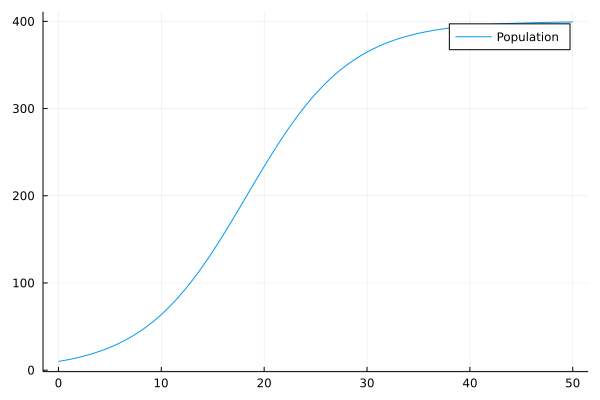

In [25]:
using Plots

h = 0.01
a, b = 0, 50
domain = a:h:b

alpha = 0.2
beta = 0.0005
P0 = 10.0

Y = implicit_euler(logistic(alpha, beta), P0, a, b, h)
plot(domain, Y, label="Population")

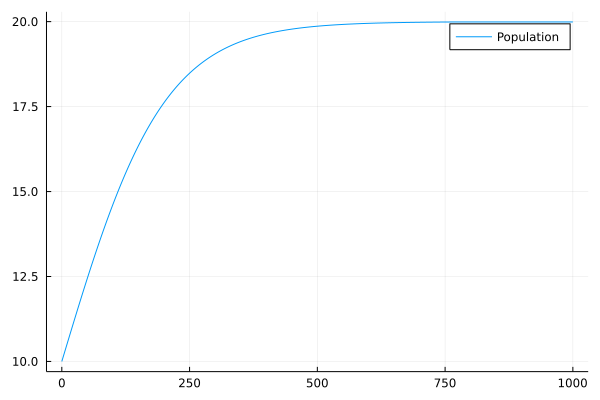

In [26]:
a, b = 0, 1000
domain = a:h:b

alpha = 0.01
beta = 0.0005
P0 = 10.0

Y = implicit_euler(logistic(alpha, beta), P0, a, b, h)
plot(domain, Y, label="Population")

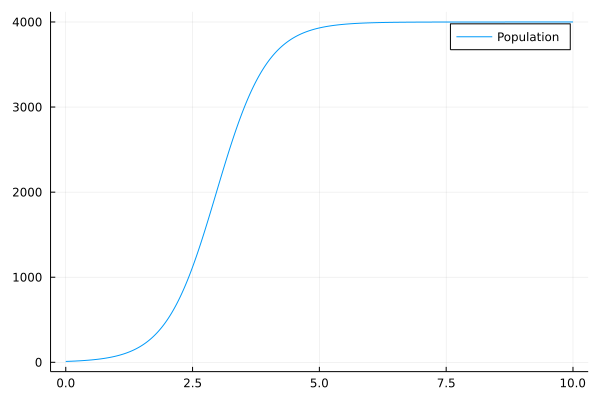

In [31]:
a, b = 0, 10
domain = a:h:b

alpha = 2.0
beta = 0.0005
P0 = 10.0

Y = implicit_euler(logistic(alpha, beta), P0, a, b, h)
plot(domain, Y, label="Population")

# Analytic Solution to the Logistic Equation

Consider the logistic equation $\frac{dP}{dt} = \alpha P - \beta P^2$, where $\alpha$ is a growth rate and $\beta$ is some decay rate. Let $K = \frac{\alpha}{\beta}$. Then we can rewrite the equation in the form $\frac{dP}{dt} = \alpha P(1 - \frac{\beta}{\alpha}P) = \alpha P(1 - \frac{P}{K})$. Now we can clearly see two equilibria, which matches our intuition: at $P = 0$, the population is gone and growth is zero; likewise at $P = K$ the population is stable and growth is zero. This shows that $K = \frac{\alpha}{\beta}$ is the carrying capacity of our system.

This system is a first-order nonlinear DE. An analytic solution can be found via separation of variables:

\begin{align*}
\frac{dP}{dt} &= \alpha P(1 - \frac{P}{K})\\
\frac{dP}{P(1 - \frac{P}{K})} &= \alpha dt\\
\int \frac{1}{P(1 - \frac{P}{K})} dP &= \int \alpha dt\\
\text{PFD} \implies
\int \frac{1}{P} dP + \int \frac{1}{K(1 - \frac{P}{K})} dP &= \int \alpha dt\\
\implies \ln{P} - \ln{1 - \frac{P}{K}} &= \alpha t + c\\
\ln{\frac{P}{1 - \frac{P}{K}}} &= \alpha t + c\\
\implies \frac{P}{1 - \frac{P}{K}} &= e^{\alpha t + c}\\
\text{Let } C = e^{c} \implies
\frac{P}{1 - \frac{P}{K}} &= Ce^{\alpha t}.
\end{align*}

We can identify the constant by evaluating the function at $P = P_0$, where $P_0$ is the initial population:

\begin{align*}
\frac{P_0}{1 - \frac{P_0}{K}} &= Ce^{\alpha \cdot 0}\\
\implies C &= \frac{P_0}{1 - \frac{P_0}{K}} = \frac{KP_0}{K - P_0}.
\end{align*}

Finally, we can solve for $P(t)$:

\begin{align*}
\frac{P}{1 - \frac{P}{K}} &= Ce^{\alpha t}\\
P &= (1 - \frac{P}{K}) Ce^{\alpha t}\\
P &= Ce^{\alpha t} - \frac{P}{K} Ce^{\alpha t}\\
P + \frac{P}{K} Ce^{\alpha t} &= Ce^{\alpha t}\\
P(1 + \frac{Ce^{\alpha t}}{K}) &= Ce^{\alpha t}\\
\implies P &= \frac{Ce^{\alpha t}}{(1 + \frac{Ce^{\alpha t}}{K})}
= \frac{Ce^{\alpha t}}{(1 + \frac{\beta Ce^{\alpha t}}{\alpha})}.
\end{align*}

The following is an implementation of this analytic solution.

In [46]:
function logistic_function(P0, a, b)
    K = a/b
    C = K*P0 / (K - P0)
    t -> C*exp(a*t) / (1 + C*exp(a*t) / K)
end

logistic_function (generic function with 1 method)

# Comparison of Solutions

Let's compare the three solutions we've implemented so far. First, recall our implementation of the explicit Euler Method:

In [48]:
function explicit_euler(f, x0, domain)
    n = length(domain)
    # Assumes an evenly spaced domain
    h = domain[2] - domain[1]
    
    yhat = Array{Float64}(undef, n)
    yhat[1] = x0
    
    for i in 2:n
        yn = yhat[i-1]
        tn = domain[i-1]
        yhat[i] = yn + h*f(yn)
    end
    
    yhat
end

explicit_euler (generic function with 1 method)

comparison

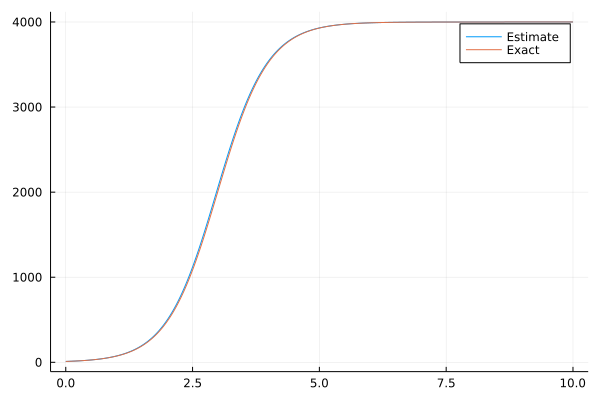

In [47]:
P = logistic_function(P0, alpha, beta)
Yexact = P.(domain)
plot(domain, [Y, Yexact], labels=["Estimate" "Exact"])

# Numerical Integration: Trapezoid Rule

Below is an implementation of the trapezoid rule, a common numerical integration technique.

In [1]:
function trapezoid(f, a, b, n)
    h = (b-a) / n
    domain = a:h:b
    
    pairs = zip(domain[1:end-1], domain[2:end])
    sum(h * (f(an) + f(bn)) / 2 for (an, bn) in pairs)
end

trapezoid (generic function with 1 method)

Even for very small choices of n, this technique quickly converges to the exact solution, $\frac{\sqrt{\pi}}{2} \text{erf} (\frac{\pi}{4}) \approx 0.64988$.

In [25]:
using SpecialFunctions

f(x) = exp(-x^2)
a, b = 0, pi/4

exact = sqrt(pi)/2 * erf(pi/4)

trapezoid.(f, a, b, [2, 4, 8, 16]), exact

([0.6388862805734845, 0.6471507696813965, 0.6491991053630145, 0.6497100964398596], 0.6498803300786572)

# Numerical Integration: Simpson's Rule

Simpson's rule is another numerical integration technique that evaluates the function at 3 points per iteration, instead of 2. The following is an implementation:

In [3]:
function simpson(f, a, b, h)
    domain = a:h:b
    
    pairs = zip(domain[1:end-1], domain[2:end])
    sum((bn - an) / 6 * (f(an) + 4f((an + bn) / 2) + f(bn)) for (an, bn) in pairs)
end

simpson (generic function with 1 method)

We can experimentally find the order of this method by considering the error at multiple values of h, and performing a linear fit on the log of the error.

In [23]:
h_vals = [1/2^n for n in 2:9]

8-element Vector{Float64}:
 0.25
 0.125
 0.0625
 0.03125
 0.015625
 0.0078125
 0.00390625
 0.001953125

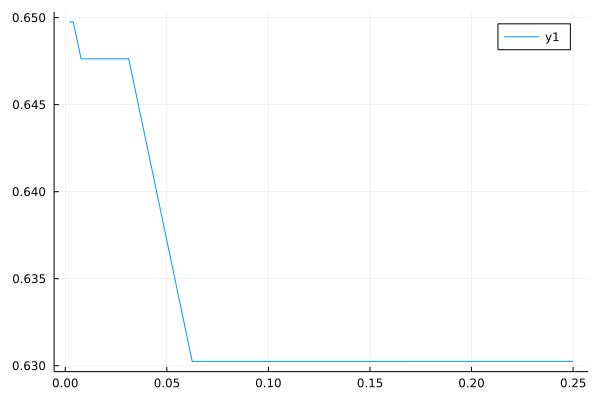

In [26]:
using Plots

error(h) = abs(exact - simpson(f, a, b, h))
plot(h_vals, simpson.(f, a, b, h_vals))

Recall our method to perform a linear fit:

In [18]:
function linear_fit(x, y)
    n = length(x)
    
    b = [sum(y); sum([xn * yn for (xn, yn) in zip(x, y)])]
    A = [n      sum(x);
         sum(x) sum([xn^2 for xn in x])]
    
    det = A[1, 1]*A[2, 2] - A[1, 2]*A[2, 1]
    inv = [A[2, 2] -A[1, 2]; -A[2, 1] A[1, 1]]
    b, a = 1/det * inv * b
    
    return a, b
end

linear_fit (generic function with 1 method)